### 載入套件與讀取資料

載入套件

In [1]:
import pandas as pd


讀取資料集檔案[線上零售資料集](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

In [2]:
df = pd.read_excel('Online Retail.xlsx')

### 資料的資訊

讀取的資料大小

In [ ]:
df.shape

541909列(rows，紀錄)，8行(columns，欄位)

資料的欄位名稱

In [ ]:
df.columns

這是一個交易發票的檔案，包含發票編號(InvoiceNo)、貨品編號(StockCode)、描述(Description)、數量(Quantity)、發票日期(InvoiceDate)、單價(UnitPrice)、顧客識別號(CustomerID)、國別(Country)等變數欄位。

數值類型的欄位資料的統計描述情形

In [ ]:
df.describe()

### 資料的內容

前五筆資料

In [ ]:
df[:5]

後五筆資料

In [ ]:
df[-5:]

### 遺失資料處理

列出CustomerID沒有資料的紀錄

In [ ]:
df[pd.isna(df.CustomerID)]

去除CustomerID沒有資料的紀錄

In [3]:
df = df.dropna(subset=['CustomerID'])

確認是否去除成功

In [ ]:
df[pd.isna(df.CustomerID)]

### 多餘資料處理

為了處理時間資料，載入datetime套件

In [4]:
from datetime import datetime

查看發票日期(InvoiceDate)

In [ ]:
print('最後日期', max(df.InvoiceDate), '最前日期', min(df.InvoiceDate))


發票日期在2010-12-01到2011-12-09間，稍微超過一年，為了方便計算起見，取2010-12-09到2011-12-09之間的資料

In [5]:
df = df[df.InvoiceDate>=datetime(2010, 12, 9, 0, 0, 0)]

### 特殊資料處理

查看數量(Quantity)為負或0的情形


In [ ]:
df[df.Quantity<=0]

當Quantity<=0時，該筆交易為取消，InvoiceNo的首字為C

查看單價(UnitPrice)為負或0的情形

In [ ]:
df[df.UnitPrice<=0]

### 群組彙整分析

統計各國的交易數(不同的發票號碼)

In [6]:
df.groupby('Country')\
.InvoiceNo.nunique()\
.sort_values(ascending=False)

Country
United Kingdom          19140
Germany                   587
France                    451
EIRE                      310
Belgium                   118
Spain                     104
Netherlands               100
Switzerland                70
Portugal                   67
Australia                  67
Italy                      53
Finland                    48
Sweden                     46
Norway                     38
Channel Islands            33
Japan                      27
Poland                     23
Denmark                    21
Cyprus                     20
Austria                    19
Singapore                  10
Malta                      10
Unspecified                 8
USA                         7
Greece                      6
Iceland                     6
Canada                      6
Israel                      6
European Community          5
Czech Republic              5
United Arab Emirates        3
Saudi Arabia                2
Bahrain                     2
Le

統計各國上的顧客數(不同的顧客識別號)

In [ ]:
df.groupby('Country')\
.CustomerID.nunique()\
.sort_values(ascending=False)

以英國(United Kingdom)為此線上商店的主要銷售國家，其餘的重要國家也大都在歐洲

### 排序分析

查看主要顧客的購買次數與金額(不包含取消)(附註：此為RFM模式中的購買頻率'Frequency'和購買金額'Monetary')

In [6]:
'''
購買紀錄
'''
df_purchase = df[df.Quantity>0]

In [ ]:
df_purchase.groupby('CustomerID') \
.InvoiceNo.nunique() \
.reset_index() \
.sort_values('InvoiceNo', ascending=False)[:20]

In [ ]:
df_purchase.assign(Total = df_purchase.UnitPrice*df_purchase.Quantity) \
.groupby('CustomerID')\
.Total.sum()\
.reset_index()\
.sort_values('Total', ascending=False)[:20]

查看主要顧客的取消次數與金額

In [7]:
'''
取消紀錄
'''
df_cancel = df[df.Quantity<0]

In [ ]:
'''
主要顧客的取消次數
'''
df_cancel.groupby('CustomerID')\
.InvoiceNo.nunique() \
.reset_index()\
.sort_values('InvoiceNo', ascending=False)[:20]

In [8]:
'''
主要顧客的取消金額
'''
major_canceller = \
df_cancel.assign(Total = df_cancel.UnitPrice*df_cancel.Quantity) \
.groupby('CustomerID')\
.Total.sum()\
.reset_index()\
.sort_values('Total',ascending=True)[:20]

major_canceller

,CustomerID,Total
1113,16446.0,-168469.60
0,12346.0,-77183.60
763,15098.0,-39267.00
1018,16029.0,-30032.23
947,15749.0,-22998.40
135,12744.0,-12158.90
720,14911.0,-11252.44
183,12931.0,-8593.15
60,12536.0,-8495.01
490,14096.0,-8043.88


取消金額較大的顧客的購買金額

In [9]:
'''
取消金額較大的顧客編號
'''
mc_list = [value for index, value in enumerate(major_canceller.CustomerID.tolist())]

In [10]:
'''
取消金額較大顧客的購買紀錄
'''
df_mc_purchase = df_purchase.loc[df_purchase.CustomerID.isin(mc_list)]

In [11]:
'''
取消金額較大顧客的購買金額
'''
major_canceller_purchase = \
df_mc_purchase.assign(Purchase_Total = df_mc_purchase.UnitPrice*df_mc_purchase.Quantity) \
.groupby('CustomerID')\
.Purchase_Total.sum() \
.reset_index() \
.sort_values('Purchase_Total',ascending=False)

In [12]:
'''
取消金額較大顧客的取消金額與購買金額
'''
major_canceller.rename(columns={"Total": "Cancel_Total"}) \
.merge(major_canceller_purchase, how='inner', on=['CustomerID']) \
.assign(Total=lambda x: x.Cancel_Total+x.Purchase_Total)

,CustomerID,Cancel_Total,Purchase_Total,Total
0,16446.0,-168469.60,168472.50,2.90
1,12346.0,-77183.60,77183.60,0.00
2,15098.0,-39267.00,39916.50,649.50
3,16029.0,-30032.23,76753.32,46721.09
4,15749.0,-22998.40,44534.30,21535.90
5,12744.0,-12158.90,21279.29,9120.39
6,14911.0,-11252.44,140359.03,129106.59
7,12931.0,-8593.15,42055.96,33462.81
8,12536.0,-8495.01,12601.83,4106.82
9,14096.0,-8043.88,65164.79,57120.91


每天的購買筆數

In [13]:
df_purchase.assign(PurchaseDate=df_purchase.InvoiceDate.apply(lambda x: x.date()))\
.groupby('PurchaseDate')\
.InvoiceNo.nunique() \
.reset_index() \
.sort_values('PurchaseDate', ascending=True)

,PurchaseDate,InvoiceNo
0,2010-12-09,98
1,2010-12-10,72
2,2010-12-12,43
3,2010-12-13,64
4,2010-12-14,81
...,...,...
293,2011-12-05,116
294,2011-12-06,110
295,2011-12-07,104
296,2011-12-08,113


每天的購買金額

In [14]:
purchase_date = df_purchase.assign(PurchaseDate=df_purchase.InvoiceDate.apply(lambda x: x.date()))\
.assign(PurchaseTotal=df_purchase.UnitPrice*df_purchase.Quantity)\
.groupby('PurchaseDate')\
.PurchaseTotal.sum() \
.reset_index() \
.sort_values('PurchaseDate', ascending=True)

purchase_date

,PurchaseDate,PurchaseTotal
0,2010-12-09,38231.90
1,2010-12-10,33650.28
2,2010-12-12,17305.77
3,2010-12-13,27642.68
4,2010-12-14,29322.30
...,...,...
293,2011-12-05,58202.21
294,2011-12-06,46144.04
295,2011-12-07,69354.21
296,2011-12-08,50519.41


### 將運算結果繪成圖形

In [17]:
pur = pd.date_range('2010-12-09', '2011-12-09')\
.to_frame(index=False)\
.rename(columns={0:'PurchaseDate'})

pur = pur.assign(PurchaseDate=pur.PurchaseDate.apply(lambda x: x.date()))

In [18]:
pur = pur.merge(purchase_date, how='left', on=['PurchaseDate'])

In [19]:
pur.loc[pd.isna(pur.PurchaseTotal), 'PurchaseTotal'] = 0

將每天的購買金額畫成線圖

In [48]:
'''
載入繪圖套件
'''
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import seaborn as sns

In [21]:
'''
顯示繪圖結果
'''
%matplotlib inline

In [61]:
'''
圖形中有中文字型的問題
參考https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b
'''
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
pd.plotting.register_matplotlib_converters() #轉換器函式庫位置

Text(0.5, 0, '購買日期')

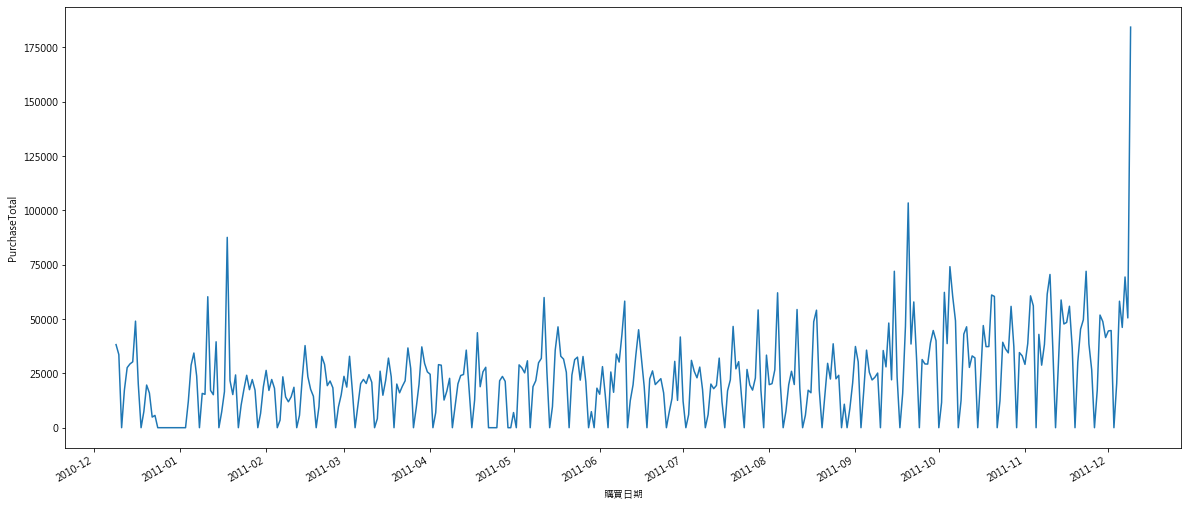

In [62]:
months = mdates.MonthLocator()  # every month

fig, ax = plt.subplots(figsize=(20,9))
chart = sns.lineplot(data=pur, x='PurchaseDate',y='PurchaseTotal')
ax.xaxis.set_major_locator(months)
fig.autofmt_xdate()
ax.set_xlabel('購買日期')
ax.set_ylabel('購買金額')

挑選2月到五月之間的日期，查看購買金額總數是否有周期變化？

In [ ]:
from datetime import date

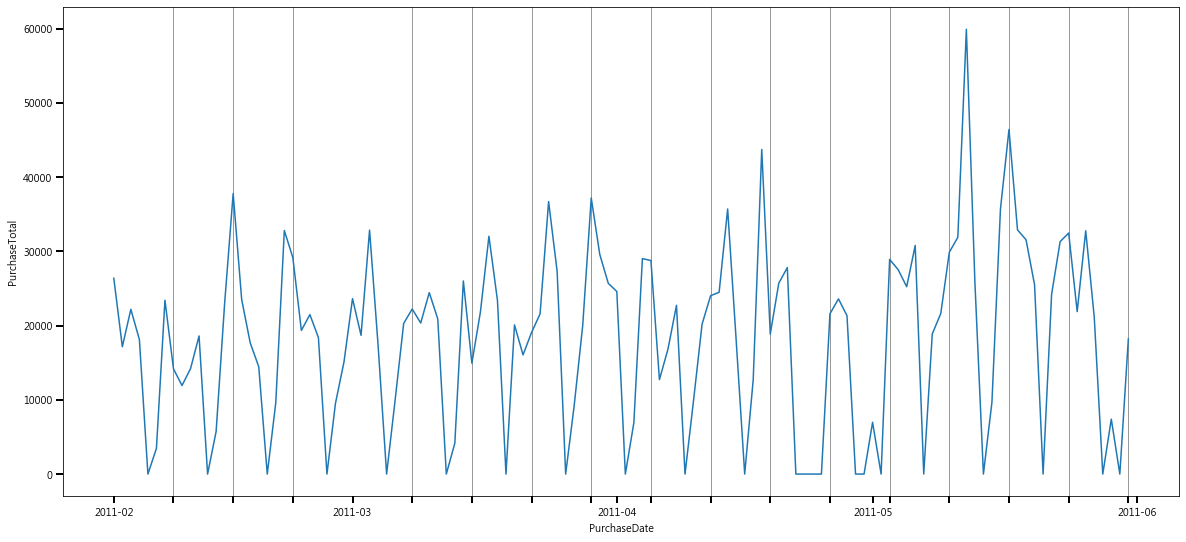

In [89]:
months = mdates.MonthLocator()  # every month
weeks = mdates.WeekdayLocator() # every week

fig, ax = plt.subplots(figsize=(20,9))
chart = sns.lineplot(data=pur.loc[pur.PurchaseDate.apply(lambda x: x>=date(2011, 2, 1) and x<=date(2011, 5, 31))], x='PurchaseDate',y='PurchaseTotal')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(weeks)

ax.xaxis.grid(True, which='minor')

ax.tick_params(which='both', width=2, length=7)


0      False
1      False
2      False
3      False
4      False
       ...  
361    False
362    False
363    False
364    False
365    False
Name: PurchaseDate, Length: 366, dtype: bool

探討一週間的哪一天的購買金額總數最高